# Learning constants using evolution

In this tutorial we consider an example with a two dimensional input data and we make use of the possibility to add constants to the model (ephemeral constants). We will thus show how to learn these constants using a purely evolutionary approach.

We will learn:

 * How to introduce ephemeral constants in a symbolic regression problem.
 
 * How to learn said constants too using an evolutionary strategy.

In [1]:
# Some necessary imports.
import dcgpy
import pygmo as pg
# Sympy is nice to have for basic symbolic manipulation.
from sympy import init_printing
from sympy.parsing.sympy_parser import *
init_printing()
# Fundamental for plotting.
from matplotlib import pyplot as plt
%matplotlib inline

#### 1 - The data

In [2]:
# We load our data from some available ones shipped with dcgpy.
# In this particular case we use the problem ratpol2 from the paper:
# Vladislavleva, Ekaterina J., Guido F. Smits, and Dick Den Hertog.
# "Order of nonlinearity as a complexity measure for models generated by symbolic regression via pareto genetic
# programming." IEEE Transactions on Evolutionary Computation 13.2 (2008): 333-349. 
X, Y = dcgpy.generate_ratpol2d()


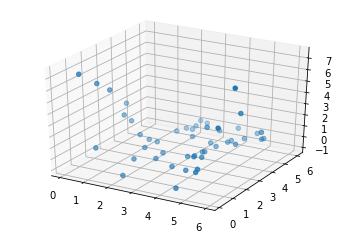

In [3]:
from mpl_toolkits.mplot3d import Axes3D  
# And we plot them as to visualize the problem.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(X[:,0], X[:,1], Y[:,0])



#### 2 - The symbolic regression problem

In [4]:
# We define our kernel set, that is the mathematical operators we will
# want our final model to possibly contain. What to choose in here is left
# to the competence and knowledge of the user. A list of kernels shipped with dcgpy 
# can be found on the online docs. The user can also define its own kernels (see the corresponding tutorial).
ss = dcgpy.kernel_set_double(["sum", "mul", "pdiv"])

In [5]:
# We instantiate the symbolic regression optimization problem
# Note how we specify to consider one ephemeral constant via
# the kwarg n_eph. We also request 100 kernels with a linear 
# layout (this allows for the construction of longer expressions) and
# we set the level back (in an attempt to skew the search towards
# more complex expressions)
udp = dcgpy.symbolic_regression(
    points = X, labels = Y, kernels=ss(), 
    rows = 1, 
    cols = 100, 
    n_eph = 1, 
    levels_back = 80)
prob = pg.problem(udp)
print(udp)

	Data dimension (points): 2
	Data dimension (labels): 1
	Data size: 50
	Kernels: [sum, mul, pdiv]
	Loss: MSE



#### 3 - The search algorithm

In [9]:
# We instantiate here the evolutionary strategy we want to use to
# search for models. Note that the evolutionary operators
# will be applied also to the constants as long as the kwarg *learn_constants* is True (default)
uda  = dcgpy.es4cgp(gen = 200000, max_mut = 4)
algo = pg.algorithm(uda)
algo.set_verbosity(1000)

#### 4 - The search

In [10]:
# We use a population of 4 individuals
pop = pg.population(prob, 4)

In [11]:
# Here is where we run the actual evolution. Note that the screen output
# will show in the terminal (not on your Jupyter notebook in case you are using it)
pop = algo.evolve(pop)

In [12]:
print("Best model loss:", pop.champion_f[0])

Best model loss: 0.38250377897772814


#### 5 - Inspecting the solution

In [13]:
# Lets have a look to the symbolic representation of our model (using sympy)
x = pop.champion_x
a = parse_expr(udp.prettier(x))[0]

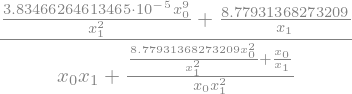

In [14]:
a = a.subs({"c1": x[0]})
a

In [15]:
# And lets see what our model actually predicts on the inputs
Y_pred = udp.predict(X, pop.champion_x)

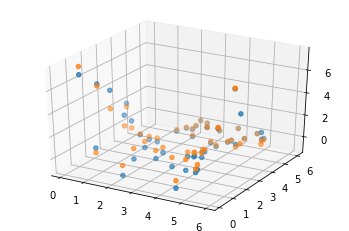

In [16]:
# Lets compare (visually) to the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(X[:,0], X[:,1], Y[:,0])
_ = ax.scatter(X[:,0], X[:,1], Y_pred[:,0])

#### 6 - Recovering the log


In [17]:
# Here we get the log of the latest call to the evolve
log = algo.extract(dcgpy.es4cgp).get_log()
gen = [it[0] for it in log]
loss = [it[2] for it in log]

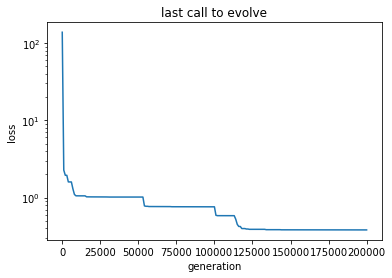

In [18]:
# And here we plot, for example, the generations against the best loss
_ = plt.semilogy(gen, loss)
_ = plt.title('last call to evolve')
_ = plt.xlabel('generation')
_ = plt.ylabel('loss')